<a href="https://colab.research.google.com/github/tsubauaaa/AITrialTraining/blob/main/Training3/AITraining3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
 # Google Driveをマウントする
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# install MeCab
!apt-get -q -y install sudo file mecab libmecab-dev mecab-ipadic-utf8 git curl python-mecab > /dev/null
!git clone --depth 1 https://github.com/neologd/mecab-ipadic-neologd.git > /dev/null 
!echo yes | mecab-ipadic-neologd/bin/install-mecab-ipadic-neologd -n > /dev/null 2>&1
!pip install mecab-python3 > /dev/null
# check path to "ipadic-neologd"
!echo `mecab-config --dicdir`"/mecab-ipadic-neologd"

!ln -s /etc/mecabrc /usr/local/etc/mecabrc

fatal: destination path 'mecab-ipadic-neologd' already exists and is not an empty directory.
/usr/lib/x86_64-linux-gnu/mecab/dic/mecab-ipadic-neologd
ln: failed to create symbolic link '/usr/local/etc/mecabrc': File exists


In [3]:
import json
import gensim
import MeCab
import pandas as pd
import re
import torch
import torch.nn as nn

In [4]:
decoder = json.JSONDecoder()
all_datasets_list = []
with open('/content/drive/My Drive/Colab Notebooks/AITraining/dataset_ja_dev.json') as f:
    line = f.readline()
    while line:
        all_datasets_list.append(decoder.raw_decode(line)[0])
        line = f.readline()

In [5]:
all_datasets_list[1]

{'language': 'ja',
 'product_category': 'wireless',
 'product_id': 'product_ja_0821731',
 'review_body': 'ホームボタン周りの気泡が全く抜けません。 返金をお願いしましたが、断られた。',
 'review_id': 'ja_0944897',
 'review_title': '欠陥品',
 'reviewer_id': 'reviewer_ja_0192786',
 'stars': '1'}

In [6]:
datasets_list = []
for data in all_datasets_list:
    review_body = data['review_body']
    stars = data['stars']
    datasets_list.append([review_body, stars])
datasets = pd.DataFrame(datasets_list, columns = ['review_body' , 'stars'])
datasets

,review_body,stars
0,味自体及び吸い心地は良いのだが、不良品が多過ぎる。私の場合５本のうち２本が蒸気も出ず、吸い込...,1
1,ホームボタン周りの気泡が全く抜けません。 返金をお願いしましたが、断られた。,1
2,新旧含めて4つのカーテンレールがあるのですが、使用出来るカーテンレールはありませんでした。 ...,1
3,予約注文でしたが、どこから特典であるpdfダウンロードすればよいのでしょうか…,1
4,前のレビューにもありましたが、片方が全く動きません。 返品しようにも、なんだかめんどくさいし...,1
...,...,...
4995,ミニオンが好きで、息子に買いました。 親子で楽しく遊んでます。,5
4996,まずレーザーの光が強いw 昔 ゲーセンで取ったヤツの3倍くらい 暗闇でレーザーの光が当たった...,5
4997,"色もち、発色もよく、ティントによくある""激しい唇の荒れ""が少ないのでとても使いやすいなと思い...",5
4998,1年前に別メーカーのバッテリーを交換して、使えましたが、スマホ確認のところで認識さらませんで...,5


In [7]:
tagger = MeCab.Tagger("-Owakati")
# param: dataset_list[]['review_body']
# return: 分かちした単語のリスト
def make_wakati(sentence):
    # MeCabで分かち書き
    sentence = tagger.parse(sentence)
    # 半角全角英数字除去
    sentence = re.sub(r'[0-9０-９a-zA-Zａ-ｚＡ-Ｚ]+', " ", sentence)
    # 記号もろもろ除去
    sentence = re.sub(r'[\．_－―─！＠＃＄％＾＆\-‐|\\＊\“（）＿■×+α※÷⇒—●★☆〇◎◆▼◇△□(：〜～＋=)／*&^%$#@!~`){}［］…\[\]\"\'\”\’:;<>?＜＞〔〕〈〉？、。・,\./『』【】「」→←○《》≪≫\n\u3000]+', "", sentence)
    # スペースで区切って形態素の配列へ
    wakati = sentence.split(" ")
    # 空の要素は削除
    wakati = list(filter(("").__ne__, wakati))
    return wakati

In [8]:
# w2vする
w2v_model = gensim.models.Word2Vec.load('/content/drive/My Drive/Colab Notebooks/AITraining/w2v/w2v.model')
word2vec = {}
no_words = []
for dataset in datasets_list:
    wakati = make_wakati(dataset[0])
    for word in wakati:
        if word in word2vec:
            continue
        if word not in list(w2v_model.wv.vocab):
            no_words.append(word)
            continue
        word2vec[word] = w2v_model.wv[word]
print(len(word2vec))
print(len(no_words))

12739
711


In [9]:
# 単語をベクトルデータに変換
# PyTorchのLSTMのインプットになるデータなので、もちろんtensor型で
def sentence2vec(sentence):
    wakati = make_wakati(sentence)
    # return torch.tensor([word2vec[w] for w in wakati])
    return [word2vec[w] for w in wakati]

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# nn.Moduleを継承して新しいクラスを作る。決まり文句
class LSTMRegressor(nn.Module):
    # モデルで使う各ネットワークをコンストラクタで定義
    def __init__(self, embedding_dim, hidden_dim):
        # 親クラスのコンストラクタ。決まり文句
        super(LSTMRegressor, self).__init__()
        # 隠れ層の次元数。これは好きな値に設定しても行列計算の過程で出力には出てこないので。
        self.hidden_dim = hidden_dim
        # LSTMの隠れ層。これ１つでOK。超便利。
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)
        # LSTMの出力を受け取って全結合してsoftmaxに食わせるための１層のネットワーク
        self.out = nn.Linear(hidden_dim, 1)

    # 順伝播処理はforward関数に記載
    def forward(self, x, h, c):
        # 2次元テンソルをLSTMに食わせられる様にviewで３次元テンソルにした上でLSTMへ流す。
        # 上記で説明した様にmany to oneのタスクを解きたいので、第二戻り値だけ使う。
        _, (h, c) = self.lstm(x, (h, c))
        # hは３次元テンソルになってしまっているので2次元に調整して全結合。
        output = self.out(h.view(-1, self.hidden_dim))
        return output

    def init_hidden(self, batch_size):
        h = torch.zeros(1, batch_size, self.hidden_dim)
        c = torch.zeros(1, batch_size, self.hidden_dim)
        return h, c

In [20]:
# EMBEDDING_DIM = 200
# HIDDEN_DIM = 128
# lstm = LSTMRegressor(EMBEDDING_DIM, HIDDEN_DIM)
# s1 = datasets_list[0][0]
# s2 = datasets_list[0][1]
# print(s1)
# # 味自体及び吸い心地は良いのだが、不良品が多過ぎる。私の場合５本のうち２本が蒸気も出ず、吸い込み も出来なかった。腹が立ってごみ箱行きでした。こんなものは２度と購入する気はない。 返品するのも交渉するのも、金額も金額だからと面倒くさがってしない方が多いのではないか？ 最初から不良品多しとでも表記しておいたら如何？
# print(make_wakati(s1))
# # ['味', '自体', '及び', '吸い', '心地', 'は', '良い', 'の', 'だ', 'が', '不', '良品', 'が', '多', '過ぎる', '私', 'の', '場合', '本', 'の', 'うち', '本', 'が', '蒸気', 'も', '出', 'ず', '吸い込み', 'も', '出来', 'なかっ', 'た', '腹', 'が', '立っ', 'て', 'ごみ箱', '行き', 'でし', 'た', 'こんな', 'もの', 'は', '度', 'と', '購入', 'する', '気', 'は', 'ない', '返品', 'する', 'の', 'も', '交渉', 'する', 'の', 'も', '金額', 'も', '金額', 'だ', 'から', 'と', '面倒く', 'さ', 'がっ', 'て', 'し', 'ない', '方', 'が', '多い', 'の', 'で', 'は', 'ない', 'か', '最初', 'から', '不', '良品', '多し', 'と', 'でも', '表記', 'し', 'て', 'おい', 'たら', '如何']
# inputs1 = sentence2vec(s1)
# inputs1 = torch.tensor(inputs1)
# print(inputs1)
# print(inputs1.shape)
# out = lstm(inputs1.view(len(inputs1), 1, -1), h, c)
# print(out)
# print(s2)

In [21]:
len_datasets = len(datasets_list)
# starsをtensorにする
category2index = {}
for i in range(len_datasets):
    star = datasets_list[i][1]
    if star in category2index: continue
    category2index[star] = len(category2index)
print(category2index)

def category2tensor(star):
    # return torch.tensor([category2index[star]], dtype=torch.float)
    return category2index[star]

print(category2tensor("2"))

{'1': 0, '2': 1, '3': 2, '4': 3, '5': 4}
1


In [22]:
# 生データのデータセットクラス
# TODO: ここでdataをsentence2vecしたほうが◎
class ReviewRawDataset(torch.utils.data.Dataset):
    def __init__(self, datasets_list, transform = None):
        self.transform = transform
        self.data = []
        self.label = []
        self.skips = 0
        for x in datasets_list:
            try:
                self.data.append(sentence2vec(x[0]))
                self.label.append(category2tensor(x[1]))
            except KeyError:
                # print(f'keyError occured: {x}')
                self.skips += 1
                continue
        print(f"skip count: {self.skips}")
        self.datanum = len(self.label)

    def __len__(self):
        return self.datanum

    def __getitem__(self, idx):
        out_label = self.label[idx]
        out_data = self.data[idx]

        if self.transform:
            out_data = self.transform(out_data)

        return out_data, out_label

In [23]:
# (最大シーケンス長×バッチサイズ×特徴量次元数)のTensorを適当にゼロ埋めして返す
class PadCollate:
    """
    a variant of callate_fn that pads according to the longest sequence in
    a batch of sequences
    """

    def __init__(self, dim=1):
        """
        args:
            dim - the dimension to be padded (dimension of time in sequences)
        """
        self.dim = dim

    def pad_collate(self, batch):
        '''
        Padds batch of variable length

        note: it converts things ToTensor manually here since the ToTensor transform
        assume it takes in images rather than arbitrary tensors.
        '''
        ## get sequence lengths
        lengths = torch.tensor([len(review) for review, star in batch])
        ## padd
        batch_review = [torch.Tensor(review) for review, star in batch]
        batch_review = torch.nn.utils.rnn.pad_sequence(batch_review, batch_first=True)
        star = torch.tensor([star for review, star in batch], dtype=torch.float)
        return batch_review, star

    def __call__(self, batch):
        return self.pad_collate(batch)

In [24]:
print(f"datasets_list length: {len(datasets_list)}")
review_dataset = ReviewRawDataset(datasets_list)
print(f"review_dataset length: {len(review_dataset)}")
n_samples = len(review_dataset)
train_size = int(len(review_dataset) * 0.8)
test_size = n_samples - train_size
train_dataset, test_dataset = torch.utils.data.random_split(review_dataset, [train_size, test_size])

print(f"train_dataset length: {len(train_dataset)}")
print(f"test_dataset length: {len(test_dataset)}")
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=PadCollate())
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=PadCollate())
print(f"train_loader length: {len(train_loader)}")
print(f"test_loader length: {len(test_loader)}")

datasets_list length: 5000
skip count: 596
review_dataset length: 4404
train_dataset length: 3523
test_dataset length: 881
train_loader length: 111
test_loader length: 881


In [25]:
train_dataiter = iter(train_loader)
# データ取得
data, target = train_dataiter.next()
print(data.shape, target.shape) # data: (batch_size, seq_len), target: (batch_size)
print(data.dtype, target.dtype) # data: (batch_size, seq_len), target: (batch_size)
print(data, target) # data: (batch_size, seq_len), target: (batch_size)
print(data[0].sum())

torch.Size([32, 276, 200]) torch.Size([32])
torch.float32 torch.float32
tensor([[[ 1.7451e+00, -1.3074e-01,  1.5752e+00,  ..., -2.0835e+00,
          -1.1018e+00,  4.5962e-01],
         [ 2.5150e+00, -1.3348e-01,  1.8852e+00,  ..., -3.7523e+00,
           4.4167e-02,  9.3814e-01],
         [ 1.6621e+00,  1.0172e+00,  3.1337e+00,  ..., -1.0852e+00,
          -1.5092e+00, -4.7079e-02],
         ...,
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00]],

        [[-2.2571e+00, -3.4708e-01,  2.6206e-01,  ...,  1.5691e+00,
           1.1910e-03, -1.7663e+00],
         [-3.3881e+00,  1.5009e+00, -1.8426e+00,  ..., -2.5546e+00,
          -6.3243e-01,  1.1873e+00],
         [-5.4255e-02, -1.2595e+00,  2.4858e-01,  ..., -3.3852e-01,
    

In [28]:
import torch.optim as optim
# 単語のベクトル次元数
EMBEDDING_DIM = 200
# 隠れ層の次元数
HIDDEN_DIM = 128
# モデル宣言
model = LSTMRegressor(EMBEDDING_DIM, HIDDEN_DIM).to(device)
# 損失関数はNLLLoss()を使う。LogSoftmaxを使う時はこれを使うらしい。
loss_function = nn.MSELoss()
# 最適化の手法はSGDで。lossの減りに時間かかるけど、一旦はこれを使う。
# optimizer = optim.SGD(model.parameters(), lr=0.01)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 各エポックの合計loss値を格納する
losses = []
for epoch in range(200):
    all_loss = 0
    for batch_index, (review, star) in enumerate(train_loader):
        # モデルが持ってる勾配の情報をリセット
        model.zero_grad()
        inputs = review.to(device)
        # (seq_len, batch_size, feature_size)に並べ替えして入力
        inputs = inputs.permute(1, 0, 2)
        h, c = model.init_hidden(review.size(0))
        h, c = h.to(device), c.to(device)
        out = model(inputs, h, c)
        # (batch_size, 1) -> (batch_size)にsqueeze
        out = torch.squeeze(out)
        target = star.to(device)
        # 正解とのlossを計算
        loss = loss_function(out, target)
        # 勾配をセット
        loss.backward()
        # 逆伝播でパラメータ更新
        optimizer.step()
        # lossを集計
        all_loss += loss.item()
    losses.append(all_loss)
    print("epoch", epoch, "\t" , "loss", all_loss / (batch_index + 1))
print("done.")

epoch 0 	 loss 2.488485510821815
epoch 1 	 loss 2.0462449563516154
epoch 2 	 loss 2.0618320059131934
epoch 3 	 loss 2.0325819404275567
epoch 4 	 loss 2.0412022176089586
epoch 5 	 loss 2.031755030692161
epoch 6 	 loss 2.009174038161029
epoch 7 	 loss 2.010254849184741
epoch 8 	 loss 1.9793981564407412
epoch 9 	 loss 2.0014914327913575
epoch 10 	 loss 1.997085250175751
epoch 11 	 loss 2.0176818091590127
epoch 12 	 loss 2.0022749696765936
epoch 13 	 loss 2.0104768018464783
epoch 14 	 loss 2.007979612092714
epoch 15 	 loss 2.008395483901909
epoch 16 	 loss 2.002003592413825
epoch 17 	 loss 1.9942161779145937
epoch 18 	 loss 1.9967693090438843
epoch 19 	 loss 1.9851991534233093
epoch 20 	 loss 2.0176796752053336
epoch 21 	 loss 2.0067720960926367
epoch 22 	 loss 1.9967560188190356
epoch 23 	 loss 1.9994155512199745
epoch 24 	 loss 2.0003269803416623
epoch 25 	 loss 2.0053582782143944
epoch 26 	 loss 1.9984173785458814
epoch 27 	 loss 1.9971694162300042
epoch 28 	 loss 1.9756423637673661
epo

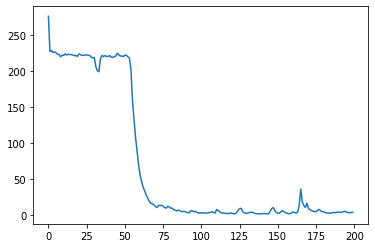

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(losses)

In [31]:
from sklearn.metrics import mean_absolute_error

# テストデータの母数計算(1500)
test_num = len(test_loader)
# 正解の件数
match = 0
# 絶対誤差用
y_preds = []
y_true = []
# 勾配自動計算OFF
with torch.no_grad():
    for batch_index, (review, star) in enumerate(test_loader):
        inputs = review.to(device)
        h, c = model.init_hidden(review.size(0))
        h, c = h.to(device), c.to(device)
        # (seq_len, batch_size, feature_size)に並べ替えして入力
        out = model(inputs.permute(1, 0, 2), h, c)
        out = torch.squeeze(out)
        predict = out.item()
        target = int(star)
        y_preds.append(predict)
        y_true.append(target)

        # predictを四捨五入して一致数を数える
        rounded_pred = round(predict)
        if rounded_pred < 0:
            rounded_pred = 0
        elif rounded_pred > 4:
            rounded_pred = 4
        # print(f"pred: {predict}, rounded pred: {rounded_pred}, target: {target}")
        if rounded_pred == target:
            match += 1
mae = mean_absolute_error(y_true, y_preds)
print(f"Correct answer rate: {match / test_num}, match: {match}, tested_num: {test_num}")
print(f"Mean Absolute Error: {mae}")

Correct answer rate: 0.358683314415437, match: 316, tested_num: 881
Mean Absolute Error: 0.9054456292382028
